#Transfer Learning.py


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive
%cd MyDrive
%cd University of Southampton
%cd Desertation Project
%cd Code
%cd Main Code files
%cd cascade_transfer_learning_medical

/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/University of Southampton
/content/drive/MyDrive/University of Southampton/Desertation Project
/content/drive/MyDrive/University of Southampton/Desertation Project/Code
/content/drive/MyDrive/University of Southampton/Desertation Project/Code/Main Code files
/content/drive/MyDrive/University of Southampton/Desertation Project/Code/Main Code files/cascade_transfer_learning_medical


In [ ]:
!nvidia-smi

Wed Sep  7 10:02:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#EDA of Melanoma Dataset

Loading the Data

In [ ]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import plotly.express as px

import os
import random
import re
import math
import time

import warnings

warnings.filterwarnings('ignore')


seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)

In [ ]:
train = pd.read_csv('siim-isic-melanoma-classification/train.csv')
test = pd.read_csv('siim-isic-melanoma-classification/test.csv')
sample = pd.read_csv('siim-isic-melanoma-classification/sample_submission.csv')

In [ ]:
train

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [ ]:
test

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity
...,...,...,...,...,...
10977,ISIC_9992485,IP_4152479,male,40.0,torso
10978,ISIC_9996992,IP_4890115,male,35.0,torso
10979,ISIC_9997917,IP_2852390,male,25.0,upper extremity
10980,ISIC_9998234,IP_8861963,male,65.0,lower extremity


In [ ]:
print(f'Train data has {train.shape[1]} features,\n \t{train.shape[0]} observations  \n \tTest data {test.shape[1]} features, \n \t{test.shape[0]} observations.\n \nTrain features are:\n{train.columns.tolist()}\n \nTest features are:\n{test.columns.tolist()}'
)

Train data has 8 features,
 	33126 observations  
 	Test data 5 features, 
 	10982 observations.
 
Train features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge', 'diagnosis', 'benign_malignant', 'target']
 
Test features are:
['image_name', 'patient_id', 'sex', 'age_approx', 'anatom_site_general_challenge']


In [ ]:
train.columns = [
    'img_name', 'patient_id', 'sex', 'age', 'location', 'target','width','height'
]

test.columns = ['img_name', 'patient_id', 'sex', 'age', 'location']



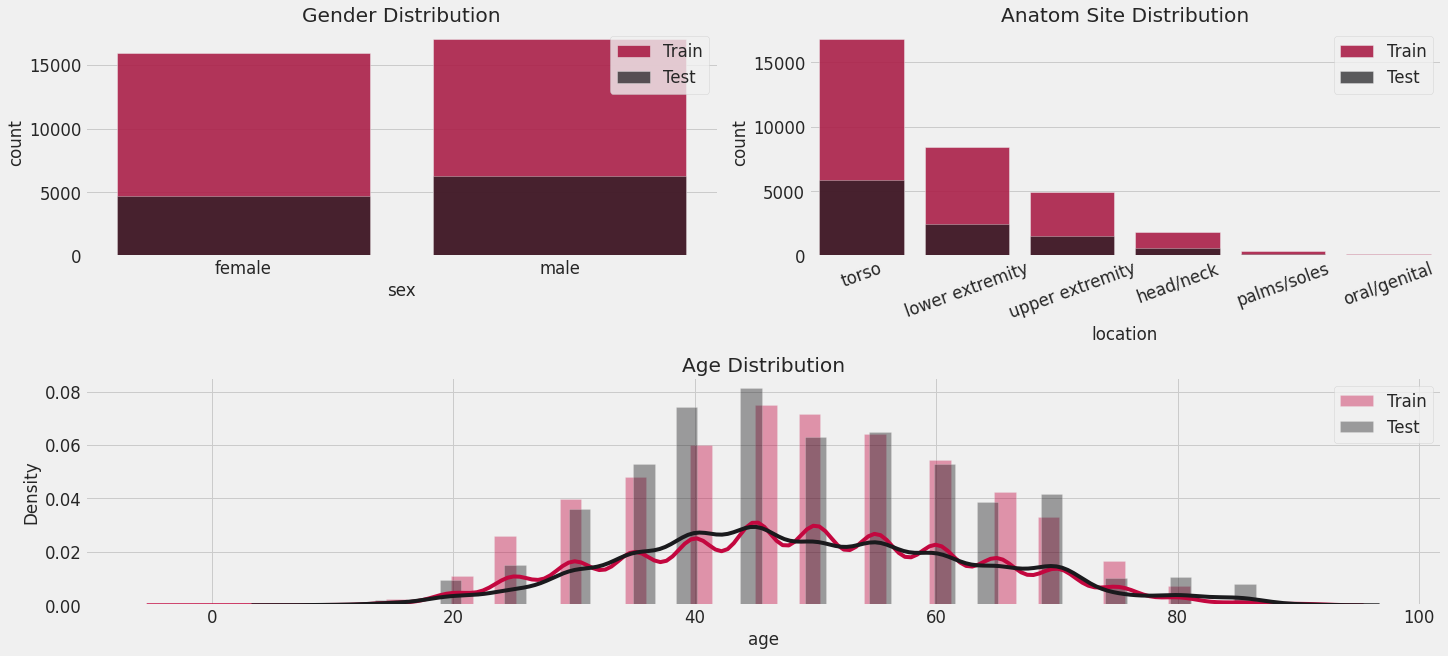

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 9))
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)

ax1 = fig.add_subplot(grid[0, :2])
ax1.set_title('Gender Distribution')
sns.countplot(train.sex.sort_values(ignore_index=True),
              alpha=0.9,
              ax=ax1,
              color='#C3073F',
              label='Train')
sns.countplot(test.sex.sort_values(ignore_index=True),
              alpha=0.7,
              ax=ax1,
              color='#1A1A1D',
              label='Test')
ax1.legend()
ax2 = fig.add_subplot(grid[0, 2:])
sns.countplot(train.location,
              alpha=0.9,
              ax=ax2,
              color='#C3073F',
              label='Train',
              order=train['location'].value_counts().index)
sns.countplot(test.location,
              alpha=0.7,
              ax=ax2,
              color='#1A1A1D',
              label='Test',
              order=test['location'].value_counts().index), ax2.set_title(
                  'Anatom Site Distribution')
ax2.legend()
plt.xticks(rotation=20)
ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Age Distribution')
sns.distplot(train.age, ax=ax3, label='Train', color='#C3073F')
sns.distplot(test.age, ax=ax3, label='Test', color='#1A1A1D')
ax3.legend()
plt.show()

In [ ]:
for df in [train, test]:
    df['location'].fillna('unknown', inplace=True)
    
train['sex'].fillna('unknown', inplace=True)

train['age'].fillna(-1, inplace=True)

In [ ]:
ids_train = train.location.values
ids_test = test.location.values
ids_train_set = set(ids_train)
ids_test_set = set(ids_test)

location_not_overlap = list(ids_train_set.symmetric_difference(ids_test_set))
n_overlap = len(location_not_overlap)
if n_overlap == 0:
    print(
        f'There are no different body parts occuring between train and test set.'
    )
else:
    print('There are some non-overlapping values between train and test set!\n')
    print(f'Different ones are:\n{pd.Series(np.setdiff1d((train.location.value_counts().index), pd.Series(test.location.value_counts().index)))}')


There are no different body parts occuring between train and test set.


In [ ]:
train.replace(['anterior torso','lateral torso','posterior torso'], 'torso', inplace=True)

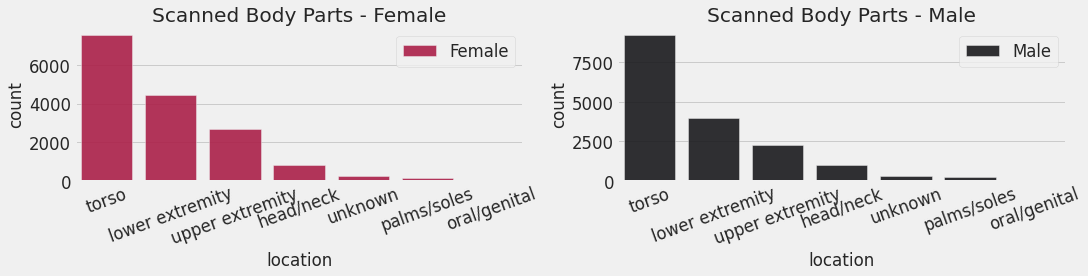

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(15, 6))
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
ax1 = fig.add_subplot(grid[1, :2])
ax1.set_title('Scanned Body Parts - Female')
sns.countplot(
    train[train['sex'] == 'female'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax1,
    color='#C3073F',
    label='Female',
    order=train['location'].value_counts().index)
ax1.legend()
plt.xticks(rotation=20)
ax2 = fig.add_subplot(grid[1, 2:])
ax2.set_title('Scanned Body Parts - Male')
sns.countplot(
    train[train['sex'] == 'male'].location.sort_values(ignore_index=True),
    alpha=0.9,
    ax=ax2,
    color='#1A1A1D',
    label='Male',
    order=train['location'].value_counts().index)

ax2.legend()
plt.xticks(rotation=20)
ax3.set_title('Malignant Ratio Per Body Part')
plt.show()

In [ ]:
fig = px.sunburst(data_frame=train,
                  path=['target', 'sex', 'location'],
                  color='sex',
                  color_discrete_sequence=black_red,
                  maxdepth=-1,
                  title='Sunburst Chart Benign/Malignant > Sex > Location')
fig.update_traces(textinfo='label+percent parent')
fig.update_layout(margin=dict(t=0, l=0, r=0, b=0))
fig.show()

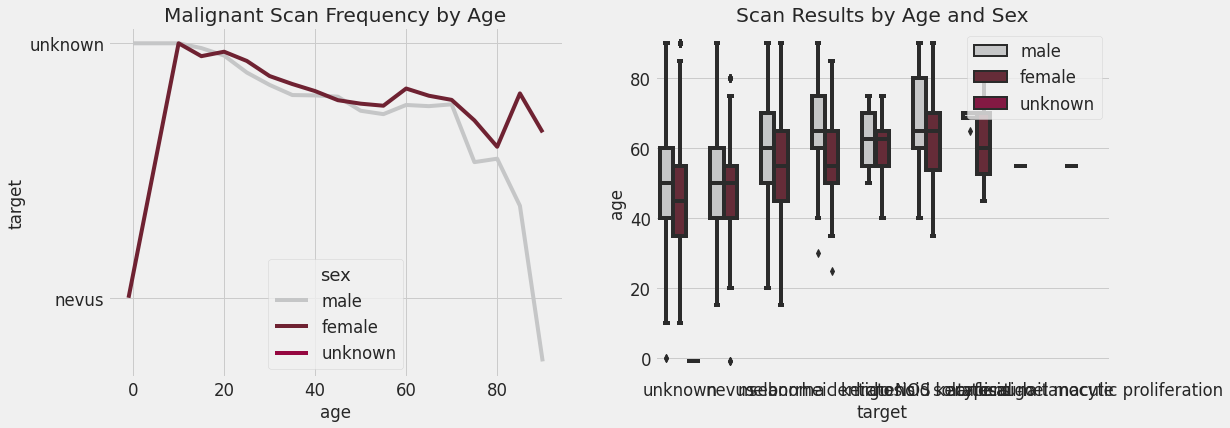

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.lineplot(x='age',
             y='target',
             data=train,
             ax=ax[0],
             hue='sex',
             palette=black_red[2:5],
             ci=None)
sns.boxplot(x='target',
            y='age',
            data=train,
            ax=ax[1],
            hue='sex',
            palette=black_red[2:5]
           )

plt.legend(loc='upper right')

ax[0].set_title('Malignant Scan Frequency by Age')
ax[1].set_title('Scan Results by Age and Sex')

plt.show()

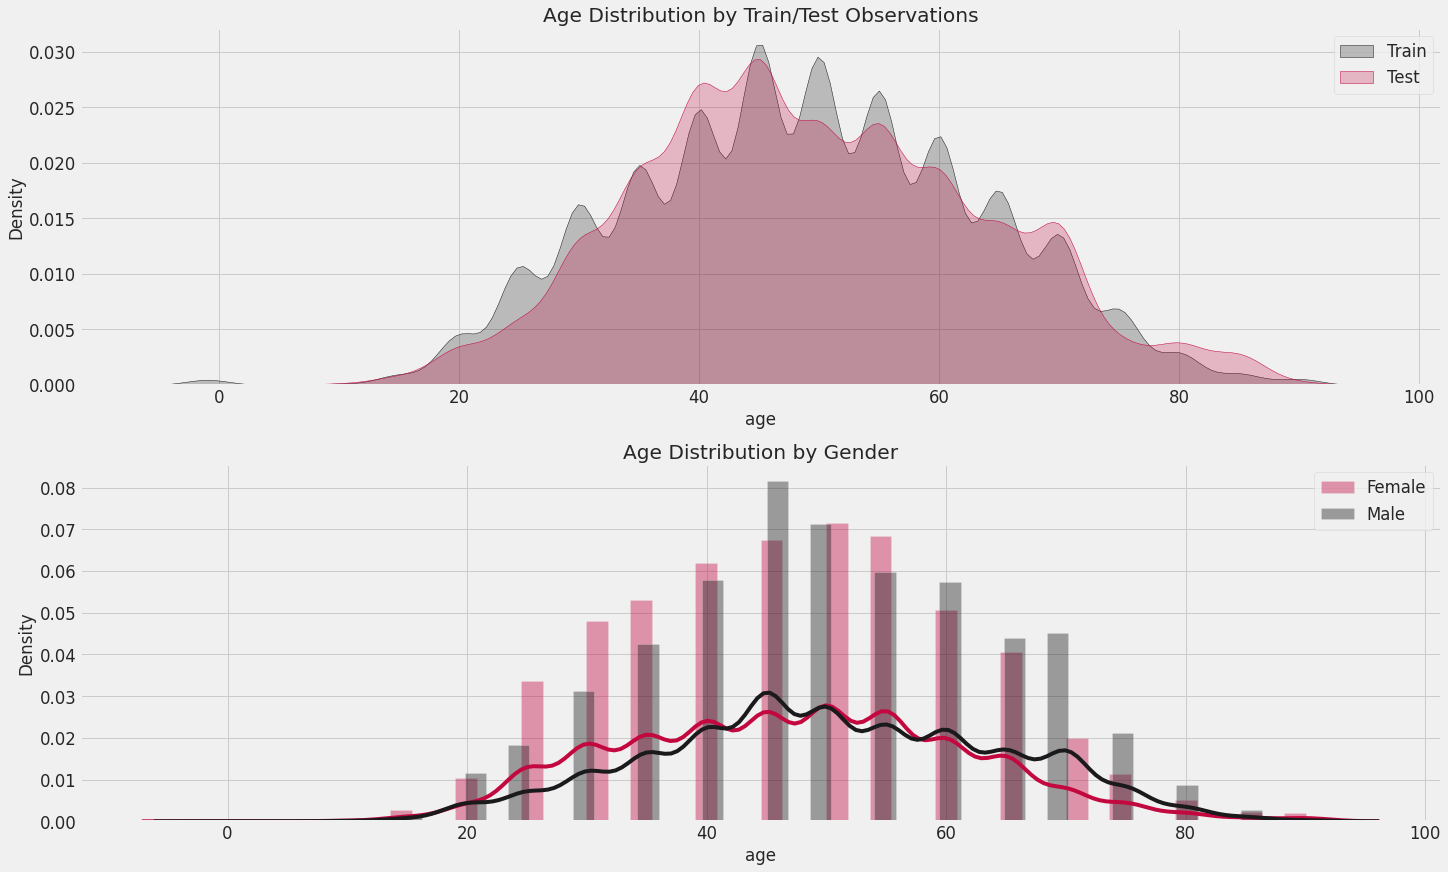

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(20, 12))
grid = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
sns.kdeplot(train[train['target'] == 0]['age'],
            shade=True,
            ax=ax1,
            color='#1A1A1D',
            label='Benign')
sns.kdeplot(train[train['target'] == 1]['age'],
            shade=True,
            ax=ax1,
            color='#C3073F',
            label='Malignant')
ax2 = fig.add_subplot(grid[0, :])
ax2.set_title('Age Distribution by Train/Test Observations')
sns.kdeplot(train.age, label='Train', shade=True, ax=ax2, color='#1A1A1D')
sns.kdeplot(test.age, label='Test', shade=True, ax=ax2, color='#C3073F')
ax2.legend()
ax3 = fig.add_subplot(grid[1, :])
ax3.set_title('Age Distribution by Gender')
sns.distplot(train[train.sex == 'female'].age,
             ax=ax3,
             label='Female',
             color='#C3073F')
sns.distplot(train[train.sex == 'male'].age,
             ax=ax3,
             label='Male',
             color='#1A1A1D')
ax3.legend()
plt.show()

In [ ]:
sex_dummies = pd.get_dummies(train['sex'], prefix='sex')
train = pd.concat([train, sex_dummies], axis=1)
sex_dummies = pd.get_dummies(test['sex'], prefix='sex')
test = pd.concat([test, sex_dummies], axis=1)
train.drop(['sex'], axis=1, inplace=True)
test.drop(['sex'], axis=1, inplace=True)

In [ ]:
anatom_dummies = pd.get_dummies(train['location'], prefix='anatom')
train = pd.concat([train, anatom_dummies], axis=1)
anatom_dummies = pd.get_dummies(test['location'], prefix='anatom')
test = pd.concat([test, anatom_dummies], axis=1)
train.drop('location', axis=1, inplace=True)
test.drop(['location'], axis=1, inplace=True)

In [ ]:
for df in [train, test]:
    df.drop('img_name', axis=1, inplace=True)

### Check for missing values

In [ ]:
def check_for_missing_and_null(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                            'percent_zero': df.isin([0]).sum() * 100 / len(df),
                            'total_zero': df.isnull().sum() * 100 / len(df) + df.isin([0]).sum() * 100 / len(df),
                           })
    return null_df
check_for_missing_and_null(train)

,columns,percent_null,percent_zero,total_zero
image_name,image_name,0.000000,0.000000,0.000000
patient_id,patient_id,0.000000,0.000000,0.000000
sex,sex,0.196220,0.000000,0.196220
age_approx,age_approx,0.205277,0.006038,0.211314
anatom_site_general_challenge,anatom_site_general_challenge,1.590895,0.000000,1.590895
diagnosis,diagnosis,0.000000,0.000000,0.000000
benign_malignant,benign_malignant,0.000000,0.000000,0.000000
target,target,0.000000,98.237034,98.237034
image_path,image_path,0.000000,0.000000,0.000000


In [ ]:
train = train.dropna()

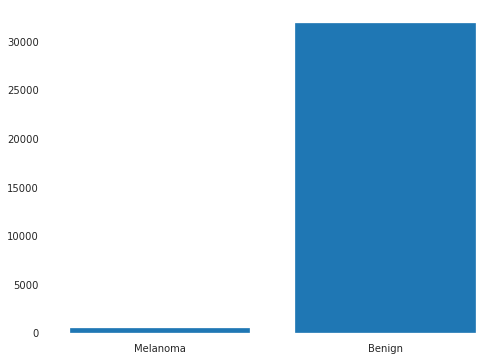

In [ ]:
plt.figure(figsize = (8,6))
x = plt.bar(["Melanoma","Benign"],[len(train[train.target==1]), len(train[train.target==0])])

There are 15743 female patients in the dataset and 16788 male patients.


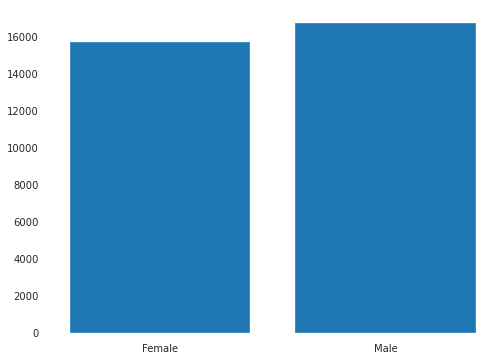

In [ ]:
female = train[train.sex == "female"]
male = train[train.sex == "male"]
plt.figure(figsize = (8,6))
x = plt.bar(
    ["Female","Male"],
    [len(female), len(male)]
)
print('There are', len(female), 'female patients in the dataset and', len(male), 'male patients.')

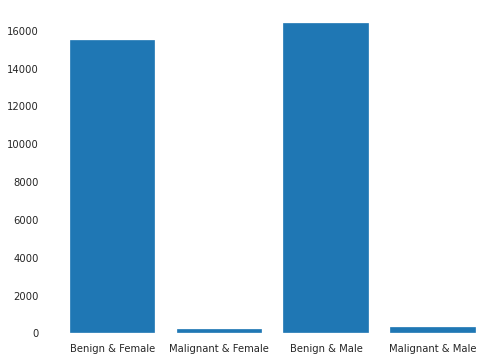

In [ ]:
plt.figure(figsize = (8,6))
x = plt.bar(
    ["Benign & Female","Malignant & Female", "Benign & Male","Malignant & Male"],
    [len(benign_cases_female), len(malignant_cases_female), len(benign_cases_male), len(malignant_cases_male)]
)

#Import Modules

In [ ]:
import os
import json
import random
import warnings
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input,ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
#from keras.applications.mobilenetv2 import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

#random.seed(1)
np.random.seed(1)
os.environ['PYTHONHASHSEED'] = str(1)
os.environ['TF_KERAS'] = str(1)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)
os.environ['TF_CUDNN_DETERMINISTIC'] = str(1)
tf.random.set_seed(69)
tf.experimental.numpy.random.seed(1)





def get_train_data():
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    # add the image_path to the train set
    train['image_path'] = train['image_name'].apply(lambda x: PATH_TO_IMAGES + "/train/" + x + IMAGE_TYPE)
    # check if the we have an image 
    train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    return train
def get_test_data():
    test = pd.read_csv(os.path.join(BASE_PATH, 'test.csv'))
    test['image_path'] = test['image_name'].apply(lambda x: PATH_TO_IMAGES + "/test/" + x + IMAGE_TYPE)
    test['image_path'] = test.apply(lambda row : check_image(row['image_path']), axis = 1)
    test = test[test['image_path'] != False]
    print("valid rows in test", test.shape[0])
    return test
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False




#Create a train and a validation dataset
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = 1, stratify = df[classToPredict])
    return train_data, val_data

#plot the history of a tensorflow model
def save_history(history, timestamp,Model_Name):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Model Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Model Accuracy")
    if SAVE_OUTPUT:
        plt.savefig(CascadeLearning+'/'+Model_Name+' '+ timestamp + "-history.png")
        with open(CascadeLearning+'/' +Model_Name+' '+ timestamp + "-history.json", 'w') as f:
            json.dump(history, f)

#plot the auc curve
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    #plt.savefig('ResNet50 1st layer Model_100epochs Model Auc(plot auc)',format='pdf')

#Data augmentation
#function to create a training image data generator
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.15, 
        width_shift_range = 0.15,
        shear_range=0.15,
        rotation_range = 90, 
        zoom_range = 0.20,
        fill_mode='nearest'
    )

    train_gen = train_idg.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen
def Average(lst):
    return sum(lst) / len(lst)

#function to create a validation image data generator
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col=['target_0','target_1'],
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return val_gen
##############################################################################################################################

def load_pretrained_model_VGG():
    base_model = VGG16(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    #base_model = tf.keras.Sequential(base_model.layers[:10])
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[:]:
        layer.trainable = True

    for idx, layer in enumerate(base_model.layers[:]):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)
    #model = base_model.layers[-165]    

    return base_model

def create_model_VGG():
    print("create model")
    model = Sequential()
    model.add(load_pretrained_model_VGG())  
    model.add(layers.Flatten())
#    model.add(layers.Dense(128, activation='relu'))
#    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model

########################################################################################################################

def load_pretrained_model_MobileNet():
    base_model = MobileNet(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    #base_model = tf.keras.Sequential(base_model.layers[:10])
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[:]:
        layer.trainable = True

    for idx, layer in enumerate(base_model.layers[:10]):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)
    #model = base_model.layers[-165]    

    return base_model

def create_model_MobileNet():
    print("create model")
    model = Sequential()
    model.add(load_pretrained_model_MobileNet())  
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model
################################################################################################################################
def load_pretrained_model_E2E():
    base_model = ResNet50(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    #base_model = tf.keras.Sequential(base_model.layers[:10])
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[:]:
        layer.trainable = True

    for idx, layer in enumerate(base_model.layers[:10]):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)
    #model = base_model.layers[-165]    

    return base_model
def create_model_E2E():
    print("create model")
    # Create a new sequentail model and add the pretrained model
    model = Sequential()
    # Add the pretrained model
    model.add(load_pretrained_model_E2E())  
    # Add a flatten layer to prepare the ouput of the cnn layer for the next layers
    model.add(layers.Flatten())
    # Add a dense (aka. fully-connected) layer. 
    # Add a dropout-layer which may prevent overfitting and improve generalization ability to unseen data.
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    # Use the Sigmoid activation function for binary predictions, softmax for n-classes
    # We use the softmax function, because we have two classes (target_0 & target_1)
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model
##################################################################################################################################
def load_pretrained_model_ResNet():
    base_model = ResNet50(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    #base_model = tf.keras.Sequential(base_model.layers[:10])
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[:]:
        layer.trainable = True

    for idx, layer in enumerate(base_model.layers[:10]):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

    return base_model

def create_model_ResNet():
    print("create model")
    model = Sequential()
    model.add(ResNet50)  
    model.add(layers.Flatten())
#    model.add(layers.Dense(512, activation='relu'))
#    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model
#################################################################################################################################

def load_pretrained_model():
    base_model = ResNet50(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )
    
    #base_model = tf.keras.Sequential(base_model.layers[:10])
    # freeze the first 15 layers of the base model. All other layers are trainable.
    for layer in base_model.layers[:]:
        layer.trainable = False

    for idx, layer in enumerate(base_model.layers[:10]):
        print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)
    #model = base_model.layers[-165]    

    return base_model
def create_model_Pretrained():
    print("create model")
    model = Sequential()
    model.add(load_pretrained_model())  
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model

def create_model(load_pretrained_model):
    print("create model")
    model = Sequential()
    model.add(load_pretrained_model)  
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(NUM_CLASSES, activation='softmax'))
    return model
def calc_f1(prec, recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=55)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    #plt.savefig('Confusion_Matrix ResNet_100epochs 1st layer Model_40epochs',format='pdf')

def pred_to_binary(pred):
    if pred < threshold:
        return 0
    else:
        return 1
########################################################################################################################################################################

CascadeLearning='Cascade all Model Layers Graph'
BASE_PATH = 'siim-isic-melanoma-classification'
PATH_TO_IMAGES = 'siim-isic-melanoma-classification/jpeg' 
IMAGE_TYPE = ".jpg"
GOOGLE_COLAB = False
BATCH_SIZE = 64
NUM_CLASSES = 2
VERBOSE_LEVEL = 2
SAVE_OUTPUT = True
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
Epochs_ResNet=150
CWD = os.getcwd()
warnings.filterwarnings('ignore')

#Data preparation
#Because we removed some values from the dataset for the EDA, we load the train and test set again.
train = get_train_data()
test = get_test_data()

# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

sex_dummies = pd.get_dummies(test['sex'], prefix='sex', dtype="int")
test = pd.concat([test, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

anatom_dummies = pd.get_dummies(test['anatom_site_general_challenge'], prefix='anatom', dtype="int")
test = pd.concat([test, anatom_dummies], axis=1)

# getting dummy variables for target column
target_dummies = pd.get_dummies(train['target'], prefix='target', dtype="int")
train = pd.concat([train, target_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)
test.drop(['sex','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))
test['age_approx'] = test['age_approx'].fillna(int(np.mean(test['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')
test['age_approx'] = test['age_approx'].astype('int')

print("rows in train", train.shape[0])
print("rows in test", test.shape[0])

#Balance the dataset
#Because we have a highly imbalanced dataset we need to balance it.

# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20%; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
print("Samples in train", train['target'].sum()/len(train))
print("Remaining rows in train set", len(train))


#Patient Overlap
#Important to note is that there are patients with multiple images taken in both train and test datasets. We, therefore, need to check that the same patient images do not appear in the training and test set.
print("Max number of images from one patient in the train set:", np.max(train.patient_id.value_counts()))
print("Max number of images from one patient in the test set:", np.max(test.patient_id.value_counts()))

# get the unique patient ids from the test and training set
ids_train = set(train.patient_id.values)
ids_test = set(test.patient_id.values)

print("There are", len(ids_train), "unique patients in the training set")
print("There are", len(ids_test), "unique patients in the test set")

# Identify patient overlap by looking at the intersection between the sets
patient_overlap = list(ids_train.intersection(ids_test))
n_overlap = len(patient_overlap)
print("There are", n_overlap, "patients in both the training and test sets")

#Images returned from the ImageDataGenerator
train_gen = get_training_gen(train)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x, cmap = 'bone')
    if c_y[0] == 1: 
        c_ax.set_title('MALIGNANT')
    else:
        c_ax.set_title('BENIGN')
    c_ax.axis('off')



valid rows in train 33126
valid rows in test 10982
rows in train 33126
rows in test 10982
Samples in train 0.5
Remaining rows in train set 1168
Max number of images from one patient in the train set: 8
Max number of images from one patient in the test set: 240
There are 787 unique patients in the training set
There are 690 unique patients in the test set
There are 0 patients in both the training and test sets
Found 1168 non-validated image filenames.


#Training the E2E Model and 1-8 layer on Pretrained Model(150 Epochs)


In [ ]:
Model_Name='E2E Model Saved'
model = create_model_E2E()
#model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./E2E_submission.csv", index=False)

    sub_df.head()


create model
layer 1 : input_2 is trainable: True
layer 2 : conv1_pad is trainable: True
layer 3 : conv1_conv is trainable: True
layer 4 : conv1_bn is trainable: True
layer 5 : conv1_relu is trainable: True
layer 6 : pool1_pad is trainable: True
layer 7 : pool1_pool is trainable: True
layer 8 : conv2_block1_1_conv is trainable: True
layer 9 : conv2_block1_1_bn is trainable: True
layer 10 : conv2_block1_1_relu is trainable: True
rows in train_df 934
rows in val_df 234
Found 934 non-validated image filenames.
Found 234 non-validated image filenames.
Epoch 1/150

Epoch 1: val_loss improved from inf to 0.72750, saving model to Cascade all Model Layers Graph/2022-08-24_09:35:54-model.hdf5
15/15 - 502s - loss: 0.8393 - accuracy: 0.5011 - auc: 0.5122 - val_loss: 0.7275 - val_accuracy: 0.5625 - val_auc: 0.6462 - 502s/epoch - 33s/step
Epoch 2/150

Epoch 2: val_loss improved from 0.72750 to 0.72677, saving model to Cascade all Model Layers Graph/2022-08-24_09:35:54-model.hdf5
15/15 - 153s - loss

100%|██████████| 234/234 [02:05<00:00,  1.86it/s]


Precision: 0.7236
Recall: 0.7607
Threshold: 0.3216
F1 Score: 0.7417


100%|██████████| 10982/10982 [2:04:51<00:00,  1.47it/s]


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)

plt.plot(history0.history['auc'], label='E2E Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)

plt.plot(history0.history['val_auc'], label='E2E Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' E2E Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
Model_Name='Pretrained plus 1st layer Model Saved'
model = create_model_Pretrained()
#model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history1 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history1.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


create model
layer 1 : input_4 is trainable: False
layer 2 : conv1_pad is trainable: False
layer 3 : conv1_conv is trainable: False
layer 4 : conv1_bn is trainable: False
layer 5 : conv1_relu is trainable: False
layer 6 : pool1_pad is trainable: False
layer 7 : pool1_pool is trainable: False
layer 8 : conv2_block1_1_conv is trainable: False
layer 9 : conv2_block1_1_bn is trainable: False
layer 10 : conv2_block1_1_relu is trainable: False
rows in train_df 934
rows in val_df 234
Found 934 non-validated image filenames.
Found 234 non-validated image filenames.
Epoch 1/150

Epoch 1: val_loss improved from inf to 0.88352, saving model to Cascade all Model Layers Graph/2022-08-24_17:12:35-model.hdf5
15/15 - 149s - loss: 0.7258 - accuracy: 0.6221 - auc: 0.6546 - val_loss: 0.8835 - val_accuracy: 0.4531 - val_auc: 0.5815 - 149s/epoch - 10s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.88352
15/15 - 142s - loss: 0.6552 - accuracy: 0.6670 - auc: 0.7294 - val_loss: 1.1886 - val_accura

100%|██████████| 234/234 [00:50<00:00,  4.60it/s]


Precision: 0.7059
Recall: 0.9231
Threshold: 0.269
F1 Score: 0.8


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)

plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' E2E and 1 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
Model_Name='Resnet plus 1st layer Model Saved'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 2nd layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history2 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history2.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


create model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 26799074  
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                           

100%|██████████| 234/234 [01:32<00:00,  2.53it/s]


Precision: 0.7664
Recall: 0.8974
Threshold: 0.2691
F1 Score: 0.8268


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n\n\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)

plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 2 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
Model_Name='Pretrained plus 2nd layer Model Saved'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 3rd layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history3 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history3.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


create model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 26800228  
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 234/234 [00:51<00:00,  4.51it/s]


Precision: 0.771
Recall: 0.8632
Threshold: 0.2695
F1 Score: 0.8145


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n\n\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.plot(history3.history['accuracy'], label='Layer 3 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3.history['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.plot(history3.history['loss'], label='Layer 3 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3.history['val_loss'], label='Layer 3 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.plot(history3.history['auc'], label='Layer 3 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3.history['val_auc'], label='Layer 3 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 3 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
Model_Name='Pretrained plus 3rd layer Model Saved'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 4th layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history4 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history4.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(Model_Name+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(Model_Name+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


create model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 2)                 74973830  
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 234/234 [01:30<00:00,  2.58it/s]


Precision: 0.6887
Recall: 0.8889
Threshold: 0.2769
F1 Score: 0.7761


'\n#prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\n#print("Chance of being malignant: {:.2f} %".format(prediction))\n\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.plot(history3.history['accuracy'], label='Layer 3 accuracy')
plt.plot(history4.history['accuracy'], label='Layer 4 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3.history['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4.history['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.plot(history3.history['loss'], label='Layer 3 Loss')
plt.plot(history4.history['loss'], label='Layer 4 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3.history['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4.history['val_loss'], label='Layer 4 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.plot(history3.history['auc'], label='Layer 3 Auc')
plt.plot(history4.history['auc'], label='Layer 4 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3.history['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4.history['val_auc'], label='Layer 4 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 4 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 5th layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history5 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history5.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./submission.csv", index=False)

    sub_df.head()


#prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
#print("Chance of being malignant: {:.2f} %".format(prediction))




create model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 74974984  
                                                                 
 flatten_2 (Flatten)         (None, 2)                 0         
                                                                 
 dense_4 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 234/234 [00:51<00:00,  4.51it/s]


Precision: 0.7185
Recall: 0.8291
Threshold: 0.2767
F1 Score: 0.7698


100%|██████████| 10982/10982 [1:12:46<00:00,  2.51it/s]


In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.plot(history3.history['accuracy'], label='Layer 3 accuracy')
plt.plot(history4.history['accuracy'], label='Layer 4 accuracy')
plt.plot(history5.history['accuracy'], label='Layer 5 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3.history['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4.history['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.plot(history5.history['val_accuracy'], label='Layer 5 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.plot(history3.history['loss'], label='Layer 3 Loss')
plt.plot(history4.history['loss'], label='Layer 4 Loss')
plt.plot(history5.history['loss'], label='Layer 5 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3.history['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4.history['val_loss'], label='Layer 4 Val_Loss')
plt.plot(history5.history['val_loss'], label='Layer 5 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.plot(history3.history['auc'], label='Layer 3 Auc')
plt.plot(history4.history['auc'], label='Layer 4 Auc')
plt.plot(history5.history['auc'], label='Layer 5 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3.history['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4.history['val_auc'], label='Layer 4 Val_Auc')
plt.plot(history5.history['val_auc'], label='Layer 5 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 5 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 6th layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history6 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history6.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)
'''
prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
print("Chance of being malignant: {:.2f} %".format(prediction))
'''



create model
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 2)                 74976138  
                                                                 
 flatten_3 (Flatten)         (None, 2)                 0         
                                                                 
 dense_6 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_3 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 234/234 [00:51<00:00,  4.51it/s]


Precision: 0.7344
Recall: 0.8034
Threshold: 0.6941
F1 Score: 0.7673


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.plot(history3.history['accuracy'], label='Layer 3 accuracy')
plt.plot(history4.history['accuracy'], label='Layer 4 accuracy')
plt.plot(history5.history['accuracy'], label='Layer 5 accuracy')
plt.plot(history6.history['accuracy'], label='Layer 6 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3.history['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4.history['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.plot(history5.history['val_accuracy'], label='Layer 5 Val_Accuracy')
plt.plot(history6.history['val_accuracy'], label='Layer 6 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.plot(history3.history['loss'], label='Layer 3 Loss')
plt.plot(history4.history['loss'], label='Layer 4 Loss')
plt.plot(history5.history['loss'], label='Layer 5 Loss')
plt.plot(history6.history['loss'], label='Layer 6 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3.history['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4.history['val_loss'], label='Layer 4 Val_Loss')
plt.plot(history5.history['val_loss'], label='Layer 5 Val_Loss')
plt.plot(history6.history['val_loss'], label='Layer 6 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.plot(history3.history['auc'], label='Layer 3 Auc')
plt.plot(history4.history['auc'], label='Layer 4 Auc')
plt.plot(history5.history['auc'], label='Layer 5 Auc')
plt.plot(history6.history['auc'], label='Layer 6 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3.history['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4.history['val_auc'], label='Layer 4 Val_Auc')
plt.plot(history5.history['val_auc'], label='Layer 5 Val_Auc')
plt.plot(history6.history['val_auc'], label='Layer 6 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 6 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 7th layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history7 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history7.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)
'''
prediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])
print("Chance of being malignant: {:.2f} %".format(prediction))
'''

create model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 2)                 74977292  
                                                                 
 flatten_4 (Flatten)         (None, 2)                 0         
                                                                 
 dense_8 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 234/234 [00:51<00:00,  4.55it/s]


Precision: 0.75
Recall: 0.7692
Threshold: 0.6001
F1 Score: 0.7595


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n'

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['accuracy'], label='E2E accuracy')
plt.plot(history1.history['accuracy'], label='Layer 1 accuracy')
plt.plot(history2.history['accuracy'], label='Layer 2 accuracy')
plt.plot(history3.history['accuracy'], label='Layer 3 accuracy')
plt.plot(history4.history['accuracy'], label='Layer 4 accuracy')
plt.plot(history5.history['accuracy'], label='Layer 5 accuracy')
plt.plot(history6.history['accuracy'], label='Layer 6 accuracy')
plt.plot(history7.history['accuracy'], label='Layer 7 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1.history['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2.history['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3.history['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4.history['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.plot(history5.history['val_accuracy'], label='Layer 5 Val_Accuracy')
plt.plot(history6.history['val_accuracy'], label='Layer 6 Val_Accuracy')
plt.plot(history7.history['val_accuracy'], label='Layer 7 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Val_Accuracy(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['loss'], label='E2E Loss')
plt.plot(history1.history['loss'], label='Layer 1 Loss')
plt.plot(history2.history['loss'], label='Layer 2 Loss')
plt.plot(history3.history['loss'], label='Layer 3 Loss')
plt.plot(history4.history['loss'], label='Layer 4 Loss')
plt.plot(history5.history['loss'], label='Layer 5 Loss')
plt.plot(history6.history['loss'], label='Layer 6 Loss')
plt.plot(history7.history['loss'], label='Layer 7 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_loss'], label='E2E Val_Loss')
plt.plot(history1.history['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2.history['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3.history['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4.history['val_loss'], label='Layer 4 Val_Loss')
plt.plot(history5.history['val_loss'], label='Layer 5 Val_Loss')
plt.plot(history6.history['val_loss'], label='Layer 6 Val_Loss')
plt.plot(history7.history['val_loss'], label='Layer 7 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Val_Loss(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['auc'], label='E2E Auc')
plt.plot(history1.history['auc'], label='Layer 1 Auc')
plt.plot(history2.history['auc'], label='Layer 2 Auc')
plt.plot(history3.history['auc'], label='Layer 3 Auc')
plt.plot(history4.history['auc'], label='Layer 4 Auc')
plt.plot(history5.history['auc'], label='Layer 5 Auc')
plt.plot(history6.history['auc'], label='Layer 6 Auc')
plt.plot(history7.history['auc'], label='Layer 7 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Auc(save_history)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0.history['val_auc'], label='E2E Val_Auc')
plt.plot(history1.history['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2.history['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3.history['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4.history['val_auc'], label='Layer 4 Val_Auc')
plt.plot(history5.history['val_auc'], label='Layer 5 Val_Auc')
plt.plot(history6.history['val_auc'], label='Layer 6 Val_Auc')
plt.plot(history7.history['val_auc'], label='Layer 7 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig(CascadeLearning+'/'+' 1 to 7 Layers Model Val_Auc(save_history)',format='pdf')

In [ ]:
Model_Name='Pretrained plus 7th layer Model Saved'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 8th layer Model Saved'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history8 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history8.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./Pretrained Model_submission.csv", index=False)

    sub_df.head()



create model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 2)                 74978446  
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                           

100%|██████████| 234/234 [01:54<00:00,  2.05it/s]


Precision: 0.5
Recall: 1.0
Threshold: 0.2814
F1 Score: 0.6667


100%|██████████| 10982/10982 [2:03:01<00:00,  1.49it/s]


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n\n\n'

#Training the model with ResNet(150 Epohs):

In [ ]:
Model_Name='ResNet Model Saved'
ResNet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in ResNet50.layers[:]:
    layer.trainable = True

for idx, layer in enumerate(ResNet50.layers[:]):
    print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

model = create_model_ResNet()
print('create model')


# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(
        train_gen, epochs=150, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./ResNet_submission.csv", index=False)

    sub_df.head()


#Training the model with VGG(150 Epohs):

In [ ]:
Model_Name='VGG Model Saved'
model = create_model_VGG()
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(train_gen, epochs=150, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./VGG_submission.csv", index=False)

    sub_df.head()

    


#Testing moels on Balanced dataset

In [ ]:
Model_Name='Melignant Model Saved'
model = create_model_malignant()
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


historyMalignant = model.fit(train_gen, epochs=1, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
#save_history(historyMalignant.history, timestamp,Model_Name)
#plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)



for i in range(0,len(y_p)):
  y_p[i]=1

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./Malignant_submission.csv", index=False)

    sub_df.head()



create model
58900480/58889256 [==============================] - 0s 0us/step
layer 1 : input_1 is trainable: True
layer 2 : block1_conv1 is trainable: True
layer 3 : block1_conv2 is trainable: True
layer 4 : block1_pool is trainable: True
layer 5 : block2_conv1 is trainable: True
layer 6 : block2_conv2 is trainable: True
layer 7 : block2_pool is trainable: True
layer 8 : block3_conv1 is trainable: True
layer 9 : block3_conv2 is trainable: True
layer 10 : block3_conv3 is trainable: True
layer 11 : block3_pool is trainable: True
layer 12 : block4_conv1 is trainable: True
layer 13 : block4_conv2 is trainable: True
layer 14 : block4_conv3 is trainable: True
layer 15 : block4_pool is trainable: True
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output 

100%|██████████| 242/242 [00:43<00:00,  5.60it/s]


Precision: 0.5083
Recall: 1.0
Threshold: 1
F1 Score: 0.674


100%|██████████| 1168/1168 [03:37<00:00,  5.37it/s]


In [ ]:
Model_Name='E2E Model Saved'
model = create_model_E2E()
#model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,
        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./E2E_submission.csv", index=False)

    sub_df.head()


create model
layer 1 : input_5 is trainable: True
layer 2 : conv1_pad is trainable: True
layer 3 : conv1_conv is trainable: True
layer 4 : conv1_bn is trainable: True
layer 5 : conv1_relu is trainable: True
layer 6 : pool1_pad is trainable: True
layer 7 : pool1_pool is trainable: True
layer 8 : conv2_block1_1_conv is trainable: True
layer 9 : conv2_block1_1_bn is trainable: True
layer 10 : conv2_block1_1_relu is trainable: True
rows in train_df 966
rows in val_df 242
Found 966 non-validated image filenames.
Found 242 non-validated image filenames.
Epoch 1/150

Epoch 1: val_loss improved from inf to 0.73700, saving model to Cascade all Model Layers Graph/2022-09-04_09:50:26-model.hdf5
16/16 - 151s - loss: 0.8419 - accuracy: 0.5197 - auc: 0.5304 - val_loss: 0.7370 - val_accuracy: 0.5469 - val_auc: 0.5574 - 151s/epoch - 9s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 0.73700
16/16 - 139s - loss: 0.8562 - accuracy: 0.4948 - auc: 0.4969 - val_loss: 0.7372 - val_accuracy: 0.4844 

100%|██████████| 242/242 [00:53<00:00,  4.53it/s]


Precision: 0.6946
Recall: 0.9431
Threshold: 0.3445
F1 Score: 0.8


100%|██████████| 1168/1168 [13:08<00:00,  1.48it/s]


'\nprediction = np.max(tf.nn.softmax(model.predict(img_array)[0])[1])\nprint("Chance of being malignant: {:.2f} %".format(prediction))\n'

In [ ]:
Model_Name='Pretrained plus 1st layer Model Saved(balanced Dataset)'
model = create_model_Pretrained()
#model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history1 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history1.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus1_submission.csv", index=False)

    sub_df.head()

create model
layer 1 : input_1 is trainable: False
layer 2 : conv1_pad is trainable: False
layer 3 : conv1_conv is trainable: False
layer 4 : conv1_bn is trainable: False
layer 5 : conv1_relu is trainable: False
layer 6 : pool1_pad is trainable: False
layer 7 : pool1_pool is trainable: False
layer 8 : conv2_block1_1_conv is trainable: False
layer 9 : conv2_block1_1_bn is trainable: False
layer 10 : conv2_block1_1_relu is trainable: False
rows in train_df 966
rows in val_df 242
Found 966 non-validated image filenames.
Found 242 non-validated image filenames.
Epoch 1/150

Epoch 1: val_loss improved from inf to 1.40328, saving model to Cascade all Model Layers Graph/2022-09-05_17:22:20-model.hdf5
16/16 - 297s - loss: 0.7422 - accuracy: 0.6180 - auc: 0.6458 - val_loss: 1.4033 - val_accuracy: 0.4531 - val_auc: 0.5601 - 297s/epoch - 19s/step
Epoch 2/150

Epoch 2: val_loss did not improve from 1.40328
16/16 - 113s - loss: 0.6727 - accuracy: 0.6656 - auc: 0.7239 - val_loss: 1.5510 - val_accura

100%|██████████| 242/242 [01:40<00:00,  2.41it/s]


Precision: 0.7357
Recall: 0.8374
Threshold: 0.522
F1 Score: 0.7833


100%|██████████| 1168/1168 [13:00<00:00,  1.50it/s]


In [ ]:
Model_Name='Pretrained plus 1st layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 2nd layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history2 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history2.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus2_submission.csv", index=False)

    sub_df.head()

In [ ]:
Model_Name='Pretrained plus 2nd layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 3rd layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history3 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history3.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus3_submission.csv", index=False)

    sub_df.head()

In [ ]:
Model_Name='Pretrained plus 3rd layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 4th layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history4 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))


#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history4.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(Model_Name+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(Model_Name+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus4_submission.csv", index=False)

    sub_df.head()

create model
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 2)                 74973830  
                                                                 
 flatten_1 (Flatten)         (None, 2)                 0         
                                                                 
 dense_2 (Dense)             (None, 128)               384       
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                         

100%|██████████| 242/242 [00:49<00:00,  4.93it/s]


Precision: 0.7163
Recall: 0.8211
Threshold: 0.3051
F1 Score: 0.7652


100%|██████████| 1168/1168 [03:50<00:00,  5.07it/s]


In [ ]:
Model_Name='Pretrained plus 4th layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 5th layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history5 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))


#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history5.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)


if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus5_submission.csv", index=False)

    sub_df.head()

create model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 74974984  
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 128)               384       
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 74,976,138
Trainable params: 51,386,378
Non-trainable params: 23,589,760
______________________

100%|██████████| 242/242 [02:05<00:00,  1.92it/s]


Precision: 0.6647
Recall: 0.9187
Threshold: 0.3019
F1 Score: 0.7713


100%|██████████| 1168/1168 [13:31<00:00,  1.44it/s]


In [ ]:
Model_Name='Pretrained plus 5th layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 6th layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history6 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))


#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history6.history, timestamp,Model_Name)
plt.savefig(Model_Name+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus6_submission.csv", index=False)

    sub_df.head()

In [ ]:
Model_Name='Pretrained plus 6th layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 7th layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history7 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history7.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./PretrainedPlus7_submission.csv", index=False)

    sub_df.head()

In [ ]:
Model_Name='Pretrained plus 7th layer Model Saved(balanced Dataset)'
trained_model = keras.models.load_model(Model_Name)
Model_Name='Pretrained plus 8th layer Model Saved(balanced Dataset)'
model = create_model(trained_model)
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='auc', mode='auto', patience=150)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/'+ timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='auc',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history8 = model.fit(
        train_gen, epochs=Epochs_ResNet, verbose=VERBOSE_LEVEL,validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))


#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history8.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')

# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')

#plt.savefig('VGG_40epochs Model_Loss.pdf',format='pdf') #saving the plot as a pdf file of name figure'''
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./Pretrained Model_submission.csv", index=False)

    sub_df.head()



In [ ]:
Model_Name='ResNet Model Saved(balanced Dataset)'
ResNet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

for layer in ResNet50.layers[:]:
    layer.trainable = True

for idx, layer in enumerate(ResNet50.layers[:10]):
    print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

model = create_model_ResNet()
print('create model')
for idx, layer in enumerate(ResNet50.layers[:10]):
    print("layer", idx + 1, ":", layer.name, "is trainable:", layer.trainable)

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(
        train_gen, epochs=150, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)

if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./ResNet_submission.csv", index=False)

    sub_df.head()


layer 1 : input_1 is trainable: True
layer 2 : conv1_pad is trainable: True
layer 3 : conv1_conv is trainable: True
layer 4 : conv1_bn is trainable: True
layer 5 : conv1_relu is trainable: True
layer 6 : pool1_pad is trainable: True
layer 7 : pool1_pool is trainable: True
layer 8 : conv2_block1_1_conv is trainable: True
layer 9 : conv2_block1_1_bn is trainable: True
layer 10 : conv2_block1_1_relu is trainable: True
create model
create model
layer 1 : input_1 is trainable: True
layer 2 : conv1_pad is trainable: True
layer 3 : conv1_conv is trainable: True
layer 4 : conv1_bn is trainable: True
layer 5 : conv1_relu is trainable: True
layer 6 : pool1_pad is trainable: True
layer 7 : pool1_pool is trainable: True
layer 8 : conv2_block1_1_conv is trainable: True
layer 9 : conv2_block1_1_bn is trainable: True
layer 10 : conv2_block1_1_relu is trainable: True
rows in train_df 966
rows in val_df 242
Found 966 non-validated image filenames.
Found 242 non-validated image filenames.
Epoch 1/150
16

100%|██████████| 242/242 [00:42<00:00,  5.65it/s]


Precision: 0.763
Recall: 0.8374
Threshold: 0.2689
F1 Score: 0.7984


100%|██████████| 1168/1168 [03:36<00:00,  5.39it/s]


In [ ]:
Model_Name='VGG Model Saved(balanced Dataset)'
model = create_model_VGG()
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)
history0 = model.fit(train_gen, epochs=150, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
save_history(history0.history, timestamp,Model_Name)
plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./VGG_submission.csv", index=False)

    sub_df.head()

    


create model
58900480/58889256 [==============================] - 0s 0us/step
layer 1 : input_2 is trainable: True
layer 2 : block1_conv1 is trainable: True
layer 3 : block1_conv2 is trainable: True
layer 4 : block1_pool is trainable: True
layer 5 : block2_conv1 is trainable: True
layer 6 : block2_conv2 is trainable: True
layer 7 : block2_pool is trainable: True
layer 8 : block3_conv1 is trainable: True
layer 9 : block3_conv2 is trainable: True
layer 10 : block3_conv3 is trainable: True
layer 11 : block3_pool is trainable: True
layer 12 : block4_conv1 is trainable: True
layer 13 : block4_conv2 is trainable: True
layer 14 : block4_conv3 is trainable: True
layer 15 : block4_pool is trainable: True
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output 

100%|██████████| 242/242 [00:40<00:00,  5.95it/s]


Precision: 0.6938
Recall: 0.9024
Threshold: 0.2691
F1 Score: 0.7845


100%|██████████| 1168/1168 [03:29<00:00,  5.57it/s]


#The model resuts all 0 and 1(No Training):

##Import Modules

In [ ]:
Model_Name='Melignant Model Saved'
model = create_model_malignant()
model.summary()

# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")
timestamp = str(today) + "_" + str(current_time)

callback_list = []

# if the model does not improve for 50 epochs, stop the training
stop_early = EarlyStopping(monitor='val_loss', mode='auto', patience=50)
callback_list.append(stop_early)

# if the output of the model should be saved, create a checkpoint callback function
if SAVE_OUTPUT:
    # set the weight path for saving the model
    weight_path = CascadeLearning+'/' + timestamp + "-model.hdf5"
    # create the model checkpoint callback to save the model wheights to a file
    checkpoint = ModelCheckpoint(
        weight_path,
        save_weights_only=True,
        verbose=VERBOSE_LEVEL,
        save_best_only=True,
        monitor='val_loss',
        overwrite=True,
        mode='auto',
    )
    # append the checkpoint callback to the callback list
    callback_list.append(checkpoint)


#Model Training
# create a training and validation dataset from the train df
train_df, val_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])

# because we do not need the target column anymore we can drop it
train_df.drop(['target'], axis=1, inplace=True)
val_df.drop(['target'], axis=1, inplace=True)

# call the generator functions
train_gen = get_training_gen(train_df)
val_gen = get_validation_gen(val_df)
valX, valY = val_gen.next()


LEARNING_RATE = 2e-5
OPTIMIZER = Adam(lr=LEARNING_RATE)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


'''model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),           loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.0)])

'''



historyMalignant = model.fit(train_gen, epochs=1, verbose=VERBOSE_LEVEL, validation_data=(valX, valY))
#        callbacks=callback_list, validation_data=(valX, valY))

#Save Model
type(model)
model.save(Model_Name)


#Model Evaluation
# plot model history
#save_history(historyMalignant.history, timestamp,Model_Name)
#plt.savefig(CascadeLearning+'/'+Model_Name+'  Model Accuracy(save_history)',format='pdf')


# plot the auc
y_t = [] # true labels
y_p = [] # predictions

# iterate over the validation df and make a prediction for each image
for i in tqdm(range(val_df.shape[0])):
    y_true = val_df.iloc[i].target_1
    image_path = val_df.iloc[i].image_path

    img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img = keras.preprocessing.image.img_to_array(img)
    img = img / 255
    img_array = tf.expand_dims(img, 0)
    y_pred = model.predict(img_array)
    y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]

    y_t.append(y_true)
    y_p.append(y_pred)



for i in range(0,len(y_p)):
  y_p[i]=1

plot_auc(y_t, y_p)
plt.savefig(CascadeLearning+'/'+Model_Name+' Model Auc(plot auc)',format='pdf')

# calculate the precision, recall and the thresholds
precision, recall, thresholds = precision_recall_curve(y_t, y_p)

# calculate the f1 score
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]

# get the index from the highest f1 score
idx = np.argmax(f1score)

# get the precision, recall, threshold and the f1score
precision = round(precision[idx], 4)
recall = round(recall[idx], 4)
threshold = round(thresholds[idx], 4)
f1score = round(f1score[idx], 4)

print('Precision:', precision)
print('Recall:', recall)
print('Threshold:', threshold)
print('F1 Score:', f1score)


y_pred_binary = [pred_to_binary(x) for x in y_p]

#Confusion Matrix
cm =  confusion_matrix(y_t, y_pred_binary)
cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label)
plt.savefig(CascadeLearning+'/'+Model_Name+' Confusion_Matrix',format='pdf')
#The model predicted 191 images correclty, but failed on 43.

#Inference
# Show a prediction for a random image
image_path = test.iloc[0].image_path
img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
img = keras.preprocessing.image.img_to_array(img)
img = img / 255
img_array = tf.expand_dims(img, 0)



if SAVE_OUTPUT:
    # save the model to a json file
    model_json = model.to_json()
    with open("./" + timestamp + "-model.json", "w") as json_file:
        json_file.write(model_json)

    # create the submission.csv file
    data=[]
    for i in tqdm(range(test.shape[0])):
        image_path = test.iloc[i].image_path
        image_name = test.iloc[i].image_name
        img = keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
        img = keras.preprocessing.image.img_to_array(img)
        img = img / 255
        img_array = tf.expand_dims(img, 0)
        y_pred = model.predict(img_array)
        y_pred = tf.nn.softmax(y_pred)[0].numpy()[1]
        data.append([image_name, y_pred])

    sub_df = pd.DataFrame(data, columns = ['image_name', 'target']) 
    sub_df.to_csv("./Malignant_submission.csv", index=False)

    sub_df.head()



create model
layer 1 : input_4 is trainable: True
layer 2 : block1_conv1 is trainable: True
layer 3 : block1_conv2 is trainable: True
layer 4 : block1_pool is trainable: True
layer 5 : block2_conv1 is trainable: True
layer 6 : block2_conv2 is trainable: True
layer 7 : block2_pool is trainable: True
layer 8 : block3_conv1 is trainable: True
layer 9 : block3_conv2 is trainable: True
layer 10 : block3_conv3 is trainable: True
layer 11 : block3_pool is trainable: True
layer 12 : block4_conv1 is trainable: True
layer 13 : block4_conv2 is trainable: True
layer 14 : block4_conv3 is trainable: True
layer 15 : block4_pool is trainable: True
layer 16 : block5_conv1 is trainable: True
layer 17 : block5_conv2 is trainable: True
layer 18 : block5_conv3 is trainable: True
layer 19 : block5_pool is trainable: True
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None,

100%|██████████| 234/234 [01:20<00:00,  2.90it/s]


Precision: 0.5
Recall: 1.0
Threshold: 1
F1 Score: 0.6667


100%|██████████| 10982/10982 [1:43:51<00:00,  1.76it/s]


#Plot all Graphs for 150 epochs


In [ ]:
cd Cascade all Model Layers Graph

/content/drive/MyDrive/University of Southampton/Desertation Project/Code/Main Code files/cascade_transfer_learning_medical/Cascade all Model Layers Graph


In [ ]:
import json
history0 = open('E2E Model Saved 2022-08-24_09:35:54-history.json')
history0 = json.load(history0)
history1 = open('Pretrained plus 1st layer Model Saved 2022-08-24_17:12:35-history.json')
history1 = json.load(history1)
history2 = open('Pretrained plus 2nd layer Model Saved 2022-08-24_22:52:27-history.json')
history2 = json.load(history2)
history3 = open('Pretrained plus 3rd layer Model Saved 2022-08-25_03:15:54-history.json')
history3 = json.load(history3)
history4 = open('Pretrained plus 4th layer Model Saved 2022-08-25_10:49:19-history.json')
history4 = json.load(history4)
history5 = open('Pretrained plus 5th layer Model Saved 2022-08-25_16:32:56-history.json')
history5 = json.load(history5)
history6 = open('Pretrained plus 6th layer Model Saved 2022-08-25_23:34:27-history.json')
history6 = json.load(history6)
history7 = open('Pretrained plus 7th layer Model Saved 2022-08-26_04:22:51-history.json')
history7 = json.load(history7)
history8 = open('Pretrained plus 8th layer Model Saved 2022-08-26_17:01:05-history.json')
history8 = json.load(history8)
historyResnet = open('ResNet Model Saved 2022-08-28_11:06:13-history.json')
historyResnet = json.load(historyResnet)
historyVGG = open('VGG Model Saved 2022-08-28_18:56:38-history.json')
historyVGG = json.load(historyVGG)


In [ ]:
Accuracy0 = Average(history0['accuracy'])
Accuracy1 = Average(history1['accuracy'])
Accuracy2 = Average(history2['accuracy'])
Accuracy3 = Average(history3['accuracy'])
Accuracy4 = Average(history4['accuracy'])
Accuracy5 = Average(history5['accuracy'])
Accuracy6 = Average(history6['accuracy'])
Accuracy7 = Average(history7['accuracy'])
Accuracy8 = Average(history8['accuracy'])
AccuracyResnet = Average(historyResnet['accuracy'])
AccuracyVGG = Average(historyVGG['accuracy'])
  
# Printing average of the list
print("Accuracy E2E =", round(Accuracy0,4))
print("Accuracy Layer 1 =", round(Accuracy1, 4))
print("Accuracy Layer 2 =", round(Accuracy2, 4))
print("Accuracy Layer 3 =", round(Accuracy3, 4))
print("Accuracy Layer 4 =", round(Accuracy4, 4))
print("Accuracy Layer 5 =", round(Accuracy5, 4))
print("Accuracy Layer 6 =", round(Accuracy6, 4))
print("Accuracy Layer 7 =", round(Accuracy7, 4))
print("Accuracy Layer 8 =", round(Accuracy8, 4))
print("Accuracy ResNet =", round(AccuracyResnet, 4))
print("Accuracy VGG =", round(AccuracyVGG, 4))


Accuracy E2E = 0.6864
Accuracy Layer 1 = 0.7373
Accuracy Layer 2 = 0.7432
Accuracy Layer 3 = 0.7194
Accuracy Layer 4 = 0.7472
Accuracy Layer 5 = 0.7465
Accuracy Layer 6 = 0.7216
Accuracy Layer 7 = 0.6546
Accuracy Layer 8 = 0.683
Accuracy ResNet = 0.9323
Accuracy VGG = 0.9093


In [ ]:
names = ['Accuracy ResNet', 'Accuracy VGG', 'Accuracy E2E','Accuracy TCL']
values = [AccuracyResnet, AccuracyVGG,Accuracy0, Accuracy4]

plt.figure(figsize=(9, 3))

plt.subplot(131)
plt.bar(names, values)
plt.subplot(132)
plt.scatter(names, values)
plt.subplot(133)
plt.plot(names, values)
plt.suptitle('Categorical Plotting')
plt.show()

In [ ]:
F1_VGG= 0.8077
F1_Resnet= 0.7893
F1_E2E= 0.7417
F1_L1= 0.8
F1_L2= 0.8145
F1_L3= 0.8268
F1_L4= 0.7761
F1_L5= 0.7698
F1_L6= 0.7673
F1_L7= 0.7595
F1_L8= 0.6667





In [ ]:
import plotly.graph_objects as go
fig = go.Figure( go.Scatter(x=names, y=values ) )
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure(
    data=[go.Bar(x=names, y=values)],
    layout_title_text="Transfer learning using TCL, E2E, ResNet and VGG architectures"
)
fig.show(renderer="colab")

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['accuracy'], label='E2E accuracy')
plt.plot(history1['accuracy'], label='Layer 1 accuracy')
plt.plot(history2['accuracy'], label='Layer 2 accuracy')
plt.plot(history3['accuracy'], label='Layer 3 accuracy')
plt.plot(history4['accuracy'], label='Layer 4 accuracy')
plt.plot(history5['accuracy'], label='Layer 5 accuracy')
plt.plot(history6['accuracy'], label='Layer 6 accuracy')
plt.plot(history7['accuracy'], label='Layer 7 accuracy')
plt.plot(history8['accuracy'], label='Layer 8 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig('All Layers Model Accuracy(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.plot(history5['val_accuracy'], label='Layer 5 Val_Accuracy')
plt.plot(history6['val_accuracy'], label='Layer 6 Val_Accuracy')
plt.plot(history7['val_accuracy'], label='Layer 7 Val_Accuracy')
plt.plot(history8['val_accuracy'], label='Layer 8 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig('All Layers Model Val_Accuracy(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['loss'], label='E2E Loss')
plt.plot(history1['loss'], label='Layer 1 Loss')
plt.plot(history2['loss'], label='Layer 2 Loss')
plt.plot(history3['loss'], label='Layer 3 Loss')
plt.plot(history4['loss'], label='Layer 4 Loss')
plt.plot(history5['loss'], label='Layer 5 Loss')
plt.plot(history6['loss'], label='Layer 6 Loss')
plt.plot(history7['loss'], label='Layer 7 Loss')
plt.plot(history8['loss'], label='Layer 8 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig('All Layers Model Loss(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_loss'], label='E2E Val_Loss')
plt.plot(history1['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4['val_loss'], label='Layer 4 Val_Loss')
plt.plot(history5['val_loss'], label='Layer 5 Val_Loss')
plt.plot(history6['val_loss'], label='Layer 6 Val_Loss')
plt.plot(history7['val_loss'], label='Layer 7 Val_Loss')
plt.plot(history8['val_loss'], label='Layer 8 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig('All Layers Model Val_Loss(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['auc'], label='E2E Auc')
plt.plot(history1['auc'], label='Layer 1 Auc')
plt.plot(history2['auc'], label='Layer 2 Auc')
plt.plot(history3['auc'], label='Layer 3 Auc')
plt.plot(history4['auc'], label='Layer 4 Auc')
plt.plot(history5['auc'], label='Layer 5 Auc')
plt.plot(history6['auc'], label='Layer 6 Auc')
plt.plot(history7['auc'], label='Layer 7 Auc')
plt.plot(history8['auc'], label='Layer 8 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig('All Layers Model Auc(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_auc'], label='E2E Val_Auc')
plt.plot(history1['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4['val_auc'], label='Layer 4 Val_Auc')
plt.plot(history5['val_auc'], label='Layer 5 Val_Auc')
plt.plot(history6['val_auc'], label='Layer 6 Val_Auc')
plt.plot(history7['val_auc'], label='Layer 7 Val_Auc')
plt.plot(history8['val_auc'], label='Layer 8 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig('All Layers Model Val_Auc(Comparission)',format='pdf')

##Plot comparision between TCL, VGG and RESNET

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['accuracy'], label='E2E accuracy')
plt.plot(history1['accuracy'], label='Layer 1 accuracy')
plt.plot(history2['accuracy'], label='Layer 2 accuracy')
plt.plot(history3['accuracy'], label='Layer 3 accuracy')
plt.plot(history4['accuracy'], label='Layer 4 accuracy')
plt.plot(history5['accuracy'], label='Layer 5 accuracy')
plt.plot(history6['accuracy'], label='Layer 6 accuracy')
plt.plot(history7['accuracy'], label='Layer 7 accuracy')
plt.plot(history8['accuracy'], label='Layer 8 accuracy')
plt.plot(historyResnet['accuracy'], label='ResNet accuracy')
plt.plot(historyVGG['accuracy'], label='VGG accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig('All Model Accuracy(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_accuracy'], label='LE2E Val_Accuracy')
plt.plot(history1['val_accuracy'], label='Layer 1 Val_Accuracy')
plt.plot(history2['val_accuracy'], label='Layer 2 Val_Accuracy')
plt.plot(history3['val_accuracy'], label='Layer 3 Val_Accuracy')
plt.plot(history4['val_accuracy'], label='Layer 4 Val_Accuracy')
plt.plot(history5['val_accuracy'], label='Layer 5 Val_Accuracy')
plt.plot(history6['val_accuracy'], label='Layer 6 Val_Accuracy')
plt.plot(history7['val_accuracy'], label='Layer 7 Val_Accuracy')
plt.plot(history8['val_accuracy'], label='Layer 8 Val_Accuracy')
plt.plot(historyResnet['val_accuracy'], label='ResNet Val_Accuracy')
plt.plot(historyVGG['val_accuracy'], label='VGG Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig('All Model Val_Accuracy(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['loss'], label='E2E Loss')
plt.plot(history1['loss'], label='Layer 1 Loss')
plt.plot(history2['loss'], label='Layer 2 Loss')
plt.plot(history3['loss'], label='Layer 3 Loss')
plt.plot(history4['loss'], label='Layer 4 Loss')
plt.plot(history5['loss'], label='Layer 5 Loss')
plt.plot(history6['loss'], label='Layer 6 Loss')
plt.plot(history7['loss'], label='Layer 7 Loss')
plt.plot(history8['loss'], label='Layer 8 loss')
plt.plot(historyResnet['loss'], label='ResNet Loss')
plt.plot(historyVGG['loss'], label='VGG Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig('All Model Loss(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_loss'], label='E2E Val_Loss')
plt.plot(history1['val_loss'], label='Layer 1 Val_Loss')
plt.plot(history2['val_loss'], label='Layer 2 Val_Loss')
plt.plot(history3['val_loss'], label='Layer 3 Val_Loss')
plt.plot(history4['val_loss'], label='Layer 4 Val_Loss')
plt.plot(history5['val_loss'], label='Layer 5 Val_Loss')
plt.plot(history6['val_loss'], label='Layer 6 Val_Loss')
plt.plot(history7['val_loss'], label='Layer 7 Val_Loss')
plt.plot(history8['val_loss'], label='Layer 8 Val_Loss')
plt.plot(historyResnet['val_loss'], label='ResNet Val_Loss')
plt.plot(historyVGG['val_loss'], label='VGG Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig('All Model Val_Loss(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['auc'], label='E2E Auc')
plt.plot(history1['auc'], label='Layer 1 Auc')
plt.plot(history2['auc'], label='Layer 2 Auc')
plt.plot(history3['auc'], label='Layer 3 Auc')
plt.plot(history4['auc'], label='Layer 4 Auc')
plt.plot(history5['auc'], label='Layer 5 Auc')
plt.plot(history6['auc'], label='Layer 6 Auc')
plt.plot(history7['auc'], label='Layer 7 Auc')
plt.plot(history8['auc'], label='Layer 8 Auc')
plt.plot(historyResnet['auc'], label='ResNet Auc')
plt.plot(historyVGG['auc'], label='VGG Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig('All Model Auc(Comparission)',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_auc'], label='E2E Val_Auc')
plt.plot(history1['val_auc'], label='Layer 1 Val_Auc')
plt.plot(history2['val_auc'], label='Layer 2 Val_Auc')
plt.plot(history3['val_auc'], label='Layer 3 Val_Auc')
plt.plot(history4['val_auc'], label='Layer 4 Val_Auc')
plt.plot(history5['val_auc'], label='Layer 5 Val_Auc')
plt.plot(history6['val_auc'], label='Layer 6 Val_Auc')
plt.plot(history7['val_auc'], label='Layer 7 Val_Auc')
plt.plot(history8['val_auc'], label='Layer 8 Val_Auc')
plt.plot(historyResnet['val_auc'], label='ResNet Val_Auc')
plt.plot(historyVGG['val_auc'], label='VGG Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig('All Model Val_Auc(Comparission)',format='pdf')

#Plot all graphs for 100 epochs

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['accuracy'][:100], label='E2E accuracy')
plt.plot(history1['accuracy'][:100], label='Layer 1 accuracy')
plt.plot(history2['accuracy'][:100], label='Layer 2 accuracy')
plt.plot(history3['accuracy'][:100], label='Layer 3 accuracy')
plt.plot(history4['accuracy'][:100], label='Layer 4 accuracy')
plt.plot(history5['accuracy'][:100], label='Layer 5 accuracy')
plt.plot(history6['accuracy'][:100], label='Layer 6 accuracy')
plt.plot(history7['accuracy'][:100], label='Layer 7 accuracy')
plt.plot(history8['accuracy'][:100], label='Layer 8 accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig('All Layers Model Accuracy(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_accuracy'][:100], label='LE2E Val_Accuracy')
plt.plot(history1['val_accuracy'][:100], label='Layer 1 Val_Accuracy')
plt.plot(history2['val_accuracy'][:100], label='Layer 2 Val_Accuracy')
plt.plot(history3['val_accuracy'][:100], label='Layer 3 Val_Accuracy')
plt.plot(history4['val_accuracy'][:100], label='Layer 4 Val_Accuracy')
plt.plot(history5['val_accuracy'][:100], label='Layer 5 Val_Accuracy')
plt.plot(history6['val_accuracy'][:100], label='Layer 6 Val_Accuracy')
plt.plot(history7['val_accuracy'][:100], label='Layer 7 Val_Accuracy')
plt.plot(history8['val_accuracy'][:100], label='Layer 8 Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig('All Layers Model Val_Accuracy(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['loss'][:100], label='E2E Loss')
plt.plot(history1['loss'][:100], label='Layer 1 Loss')
plt.plot(history2['loss'][:100], label='Layer 2 Loss')
plt.plot(history3['loss'][:100], label='Layer 3 Loss')
plt.plot(history4['loss'][:100], label='Layer 4 Loss')
plt.plot(history5['loss'][:100], label='Layer 5 Loss')
plt.plot(history6['loss'][:100], label='Layer 6 Loss')
plt.plot(history7['loss'][:100], label='Layer 7 Loss')
plt.plot(history8['loss'][:100], label='Layer 8 Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig('All Layers Model Loss(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_loss'][:100], label='E2E Val_Loss')
plt.plot(history1['val_loss'][:100], label='Layer 1 Val_Loss')
plt.plot(history2['val_loss'][:100], label='Layer 2 Val_Loss')
plt.plot(history3['val_loss'][:100], label='Layer 3 Val_Loss')
plt.plot(history4['val_loss'][:100], label='Layer 4 Val_Loss')
plt.plot(history5['val_loss'][:100], label='Layer 5 Val_Loss')
plt.plot(history6['val_loss'][:100], label='Layer 6 Val_Loss')
plt.plot(history7['val_loss'][:100], label='Layer 7 Val_Loss')
plt.plot(history8['val_loss'][:100], label='Layer 8 Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig('All Layers Model Val_Loss(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['auc'][:100], label='E2E Auc')
plt.plot(history1['auc'][:100], label='Layer 1 Auc')
plt.plot(history2['auc'][:100], label='Layer 2 Auc')
plt.plot(history3['auc'][:100], label='Layer 3 Auc')
plt.plot(history4['auc'][:100], label='Layer 4 Auc')
plt.plot(history5['auc'][:100], label='Layer 5 Auc')
plt.plot(history6['auc'][:100], label='Layer 6 Auc')
plt.plot(history7['auc'][:100], label='Layer 7 Auc')
plt.plot(history8['auc'][:100], label='Layer 8 Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig('All Layers Model Auc(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_auc'][:100], label='E2E Val_Auc')
plt.plot(history1['val_auc'][:100], label='Layer 1 Val_Auc')
plt.plot(history2['val_auc'][:100], label='Layer 2 Val_Auc')
plt.plot(history3['val_auc'][:100], label='Layer 3 Val_Auc')
plt.plot(history4['val_auc'][:100], label='Layer 4 Val_Auc')
plt.plot(history5['val_auc'][:100], label='Layer 5 Val_Auc')
plt.plot(history6['val_auc'][:100], label='Layer 6 Val_Auc')
plt.plot(history7['val_auc'][:100], label='Layer 7 Val_Auc')
plt.plot(history8['val_auc'][:100], label='Layer 8 Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig('All Layers Model Val_Auc(Comparission) for 100 epochs',format='pdf')

##Plot comparision between TCL, VGG and RESNET

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['accuracy'][:100], label='E2E accuracy')
#plt.plot(history1['accuracy'][:100], label='Layer 1 accuracy')
#plt.plot(history2['accuracy'][:100], label='Layer 2 accuracy')
#plt.plot(history3['accuracy'][:100], label='Layer 3 accuracy')
plt.plot(history4['accuracy'][:100], label='TCL Layer 4 accuracy')
#plt.plot(history5['accuracy'][:100], label='Layer 5 accuracy')
#plt.plot(history6['accuracy'][:100], label='Layer 6 accuracy')
#plt.plot(history7['accuracy'][:100], label='Layer 7 accuracy')
#plt.plot(history8['accuracy'][:100], label='Layer 8 accuracy')
plt.plot(historyResnet['accuracy'][:100], label='ResNet accuracy')
plt.plot(historyVGG['accuracy'][:100], label='VGG accuracy')
plt.legend()
plt.title("Model Accuracy")
plt.savefig('All Model Accuracy(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_accuracy'][:100], label='LE2E Val_Accuracy')
#plt.plot(history1['val_accuracy'][:100], label='Layer 1 Val_Accuracy')
#plt.plot(history2['val_accuracy'][:100], label='Layer 2 Val_Accuracy')
#plt.plot(history3['val_accuracy'][:100], label='Layer 3 Val_Accuracy')
plt.plot(history4['val_accuracy'][:100], label='TCL Layer 4 Val_Accuracy')
#plt.plot(history5['val_accuracy'][:100], label='Layer 5 Val_Accuracy')
#plt.plot(history6['val_accuracy'][:100], label='Layer 6 Val_Accuracy')
#plt.plot(history7['val_accuracy'][:100], label='Layer 7 Val_Accuracy')
#plt.plot(history8['val_accuracy'][:100], label='Layer 8 Val_Accuracy')
plt.plot(historyResnet['val_accuracy'][:100], label='ResNet Val_Accuracy')
plt.plot(historyVGG['val_accuracy'][:100], label='VGG Val_Accuracy')
plt.legend()
plt.title("Model Val_Accuracy")
plt.savefig('All Model Val_Accuracy(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['loss'][:100], label='E2E Loss')
#plt.plot(history1['loss'][:100], label='Layer 1 Loss')
#plt.plot(history2['loss'][:100], label='Layer 2 Loss')
#plt.plot(history3['loss'][:100], label='Layer 3 Loss')
plt.plot(history4['loss'][:100], label='TCL Layer 4 Loss')
#plt.plot(history5['loss'][:100], label='Layer 5 Loss')
#plt.plot(history6['loss'][:100], label='Layer 6 Loss')
#plt.plot(history7['loss'][:100], label='Layer 7 Loss')
#plt.plot(history8['loss'][:100], label='Layer 8 loss')
plt.plot(historyResnet['loss'][:100], label='ResNet Loss')
plt.plot(historyVGG['loss'][:100], label='VGG Loss')
plt.legend()
plt.title("Model Loss")
plt.savefig('All Model Loss(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_loss'][:100], label='E2E Val_Loss')
#plt.plot(history1['val_loss'][:100], label='Layer 1 Val_Loss')
#plt.plot(history2['val_loss'][:100], label='Layer 2 Val_Loss')
#plt.plot(history3['val_loss'][:100], label='Layer 3 Val_Loss')
plt.plot(history4['val_loss'][:100], label='TCL Layer 4 Val_Loss')
#plt.plot(history5['val_loss'][:100], label='Layer 5 Val_Loss')
#plt.plot(history6['val_loss'][:100], label='Layer 6 Val_Loss')
#plt.plot(history7['val_loss'][:100], label='Layer 7 Val_Loss')
#plt.plot(history8['val_loss'][:100], label='Layer 8 Val_Loss')
plt.plot(historyResnet['val_loss'][:100], label='ResNet Val_Loss')
plt.plot(historyVGG['val_loss'][:100], label='VGG Val_Loss')
plt.legend()
plt.title("Model Val_Loss")
plt.savefig('All Model Val_Loss(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['auc'][:100], label='E2E Auc')
#plt.plot(history1['auc'][:100], label='Layer 1 Auc')
#plt.plot(history2['auc'][:100], label='Layer 2 Auc')
#plt.plot(history3['auc'][:100], label='Layer 3 Auc')
plt.plot(history4['auc'][:100], label='TCL Layer 4 Auc')
#plt.plot(history5['auc'][:100], label='Layer 5 Auc')
#plt.plot(history6['auc'][:100], label='Layer 6 Auc')
#plt.plot(history7['auc'][:100], label='Layer 7 Auc')
#plt.plot(history8['auc'][:100], label='Layer 8 Auc')
plt.plot(historyResnet['auc'][:100], label='ResNet Auc')
plt.plot(historyVGG['auc'][:100], label='VGG Auc')
plt.legend()
plt.title("Model Auc")
plt.savefig('All Model Auc(Comparission) for 100 epochs',format='pdf')

In [ ]:
#def save_history(history, timestamp,Model_Name):
f = plt.figure()
f.set_figwidth(15)
plt.plot(history0['val_auc'][:100], label='E2E Val_Auc')
#plt.plot(history1['val_auc'][:100], label='Layer 1 Val_Auc')
#plt.plot(history2['val_auc'][:100], label='Layer 2 Val_Auc')
#plt.plot(history3['val_auc'][:100], label='Layer 3 Val_Auc')
plt.plot(history4['val_auc'][:100], label='Layer 4 Val_Auc')
#plt.plot(history5['val_auc'][:100], label='Layer 5 Val_Auc')
#plt.plot(history6['val_auc'][:100], label='Layer 6 Val_Auc')
#plt.plot(history7['val_auc'][:100], label='Layer 7 Val_Auc')
#plt.plot(history8['val_auc'][:100], label='Layer 8 Val_Auc')
plt.plot(historyResnet['val_auc'][:100], label='ResNet Val_Auc')
plt.plot(historyVGG['val_auc'][:100], label='VGG Val_Auc')
plt.legend()
plt.title("Model Val_Auc")
plt.savefig('All Model Val_Auc(Comparission) for 100 epochs',format='pdf')

#END